# HW-3: Variational Autoencoders

## Part 1.1



In [0]:
import numpy as np
import torch


def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
data_a = sample_data_1()

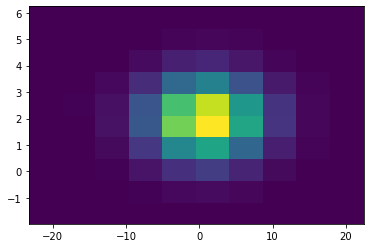

In [0]:
import matplotlib.pyplot as plt

plt.hist2d(data_a[:,0],data_a[:,1])
plt.show()

In [0]:
data_b = sample_data_2()

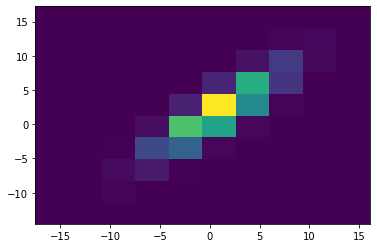

In [0]:
plt.hist2d(data_b[:,0],data_b[:,1])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

train_a, test_a, train_b, test_b = train_test_split(data_a, data_b, test_size=0.2)
train_a, val_a, train_b, val_b = train_test_split(train_a, train_b, test_size=0.125)

In [0]:
print(len(train_a), len(test_a), len(val_a))

70000 20000 10000


In [0]:
print(len(train_b), len(test_b), len(val_b))

70000 20000 10000


In [0]:
train_a[:10]

array([[-4.49201105,  3.23175209],
       [-3.98255316,  2.10059086],
       [12.34877312,  0.54563433],
       [-0.90955861,  1.92713404],
       [-5.79578697,  1.55855783],
       [-0.6830049 ,  4.37013255],
       [ 7.85546346,  2.30940075],
       [ 3.85253196,  2.27989311],
       [-4.98075294,  1.21468817],
       [ 7.44619996,  1.05934641]])

In [0]:
train_b[:10]

array([[-3.75441851, -1.012458  ],
       [-2.59432561, -1.45206865],
       [10.05318626,  8.9964026 ],
       [-0.29873783,  0.59821414],
       [-3.4932003 , -3.1174938 ],
       [-1.86600098,  2.48587262],
       [ 5.62876533,  7.06632407],
       [ 2.81913038,  4.21495901],
       [-2.67373164, -2.78433029],
       [ 6.22329424,  5.89300917]])

In [0]:
class DeterministicWarmup(object):
    def __init__(self, start_epochs=0, max_epochs=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1 / max_epochs
        self.start_epochs = start_epochs

    def __iter__(self):
        return self

    def __next__(self, epoch):
        if epoch >= self.start_epochs:
            t = self.t + self.inc
            self.start_epochs += 1
            self.t = max(self.t_max, t)
        return self.t

In [0]:
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch import optim
import torch.nn.functional as F

num_features = 2
warmup = DeterministicWarmup(max_epochs=25)

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples, scalar, beta=warmup):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        self.scalar = scalar
        self.beta = beta
        self.out_features = self.latent_features + 1  if self.scalar else 2 * self.latent_features

        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=32),
            nn.ELU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=(self.latent_features*2))
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ELU(),
            nn.Linear(in_features=32, out_features=self.out_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)

        z = self.reparameterize(mu,log_var)  

        x_sample = self.decoder(z)

        if self.scalar:
            x_mu, x_log_var = torch.split(x_sample, self.latent_features, dim=-1)
            x_log_var = torch.ones_like(x_mu) * x_log_var
        else:
            x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        
        outputs["x_hat"] = self.reparameterize(x_mu,x_log_var)  
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        outputs["x_mu"] = x_mu
        outputs["x_log_var"] = x_log_var

        return outputs

    def reparameterize(self,mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def sample(self, z):
        x_sample = self.decoder(z)
        x_mu, x_log_var = torch.chunk(x_sample, 2, dim=-1)
        full_generation_path = self.reparameterize(x_mu, x_log_var)  
        without_decoder_noise = x_mu
        return full_generation_path, without_decoder_noise

    def loss_function(self, t, mu, log_var, x_mu,x_log_var, epoch):
        likelihood = torch.sum(-log_normal(t,x_mu,x_log_var),dim=1)
        kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
        nll = torch.mean(likelihood) / np.log(2) / 2
        kl = torch.mean(kl)
        self.beta.__next__(epoch)
        ELBO = nll + self.beta.t*kl
        
        return ELBO, kl, nll

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2 * np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * torch.exp(log_var) + eps)

In [0]:
latent_features = 2
num_samples = 10
net = VariationalAutoencoder(latent_features, num_samples, False)

In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [0]:
import matplotlib.pyplot as plt

def fit(data_train, data_val, data_test, epochs=50):

    losses, val_losses =[],[]
    batch_size = 1000

    train = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
    val = torch.utils.data.DataLoader(dataset=data_val, batch_size=batch_size, shuffle=True)
    test = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True)


    losses = []
    val_losses = []
    kls = []
    val_kls = []
    nlls = []
    val_nlls = []

    for epoch in range(epochs):

        loss = 0
        
        for train_X in train:
            
            outputs = net(train_X.float())
            
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
            
            loss, kl, nll = net.loss_function(train_X, mu, log_var,x_mu, x_log_var, epoch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.data.numpy())
            kls.append(kl.data.numpy())
            nlls.append(nll.data.numpy())

            
        with torch.no_grad():

            for val_X in val:
                
                outputs = net(val_X.float())

                x_hat = outputs["x_hat"]
                mu, log_var = outputs["mu"], outputs["log_var"]
                x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
                z = outputs["z"]

                val_loss, val_kl, val_nll = net.loss_function(val_X, mu, log_var, x_mu, x_log_var, epoch)

                val_losses.append(val_loss.data.numpy())
                val_kls.append(val_kl.data.numpy())
                val_nlls.append(val_nll.data.numpy())

        if epoch % 10 == 0:
            print('Epoch {}: loss {} kl {} nll {} '.format(epoch,loss.item(),kl.item(),nll.item()))

    test_losses = []
    test_kls = []
    test_nlls = []
    for test_X in test:
    
        outputs = net(test_X.float())

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        x_mu, x_log_var = outputs["x_mu"], outputs["x_log_var"]
        z = outputs["z"]

        test_loss, test_kl, test_nll = net.loss_function(test_X, mu, log_var, x_mu, x_log_var, epoch)

        test_losses.append(test_loss.data.numpy())
        test_kls.append(test_kl.data.numpy())
        test_nlls.append(test_nll.data.numpy())

    print('test loss {}  test kl {} test nll {} '.format(np.mean(test_losses),np.mean(test_kls),np.mean(test_nlls)))
    
    f, axarr = plt.subplots(1,3, figsize=(18,6))

    ax = axarr[0]
    ax.set_title('ELBO')
    ax.plot(losses, label = "ELBO_train_loss")
    ax.plot(np.arange(0, len(losses),(len(losses)/len(val_losses))),val_losses, label = "ELBO_val_loss")

    ax = axarr[1]
    ax.set_title('KL')
    ax.plot(kls, label = "kl_train_loss")
    ax.plot(np.arange(0, len(kls),(len(kls)/len(val_kls))),val_kls, label = "KL_val_loss")

    ax = axarr[2]
    ax.set_title('NLL')
    ax.plot(nlls, label = "NLL_train_loss")
    ax.plot(np.arange(0, len(nlls),(len(nlls)/len(val_nlls))),val_nlls, label = "NLL_val_loss")
    plt.show()

In [0]:
def sample(model, n=100000):
    with torch.no_grad():
        z = torch.randn([n, 2])
        x, mu_x = model.sample(z)
        
    plt.plot(x[:, 0], x[:, 1], 'o', label="X")
    plt.plot(mu_x[:, 0], mu_x[:, 1], 'o', label="Mean")
    plt.legend()
    plt.show()

Epoch 0: loss 6.559329413256243 kl 1.321107029914856 nll 5.2382223833413875 
Epoch 10: loss 3.245771088435521 kl 0.01730797253549099 nll 3.2215399265133047 
Epoch 20: loss 3.2091734591786 kl 0.003901863005012274 nll 3.2021501060489745 
Epoch 30: loss 3.1881690117197614 kl 0.001009369152598083 nll 3.1859483994676303 
Epoch 40: loss 3.1946112564605706 kl 0.00024129074881784618 nll 3.193983900519465 
test loss 3.207634399959067  test kl 8.58640851220116e-05 test nll 3.2073802422641955 


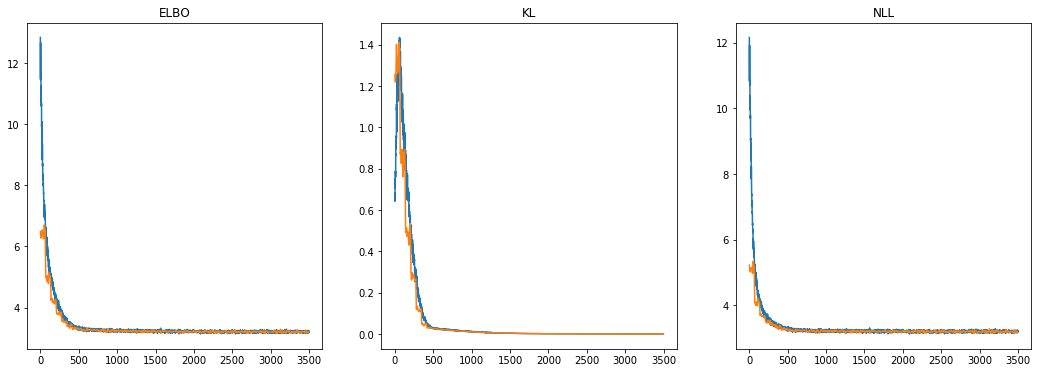

In [0]:
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, False, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(train_a, val_a, test_a)

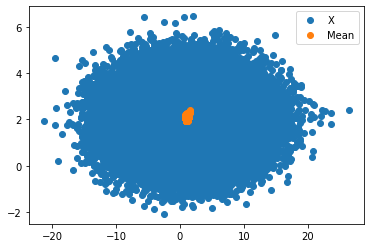

In [0]:
sample(net)

Epoch 0: loss 9.304128911975965 kl 0.37073445320129395 nll 8.933394458774671 
Epoch 10: loss 3.915252328236819 kl 0.06830133497714996 nll 3.819630459268809 
Epoch 20: loss 3.9048927339123187 kl 0.016356369480490685 nll 3.8754512692199645 
Epoch 30: loss 3.8891229593533088 kl 0.003986173775047064 nll 3.8803533763962794 
Epoch 40: loss 3.9504211374763845 kl 0.001353006693534553 nll 3.946903320236176 
test loss 3.898982006383311  test kl 0.00026208662893623114 test nll 3.8982062299436153 


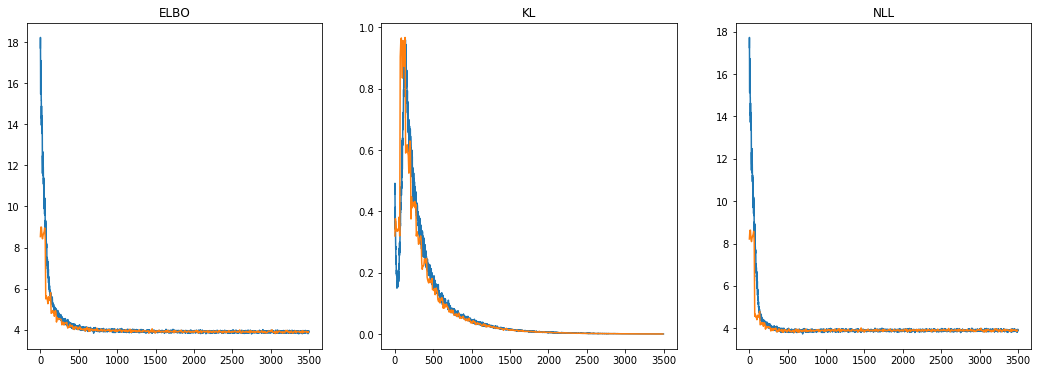

In [0]:
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, True, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(train_a, val_a, test_a)

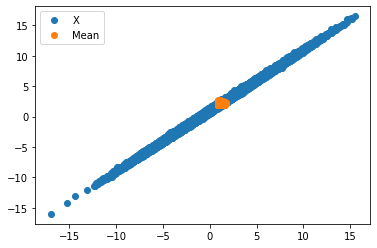

In [0]:
sample(net)

Epoch 0: loss 7.900228475825447 kl 0.6661047339439392 nll 7.234123741881508 
Epoch 10: loss 3.9466611475448996 kl 0.05934465304017067 nll 3.863578635523835 
Epoch 20: loss 3.8652498979091834 kl 0.008285640738904476 nll 3.85033574476542 
Epoch 30: loss 3.867465906632481 kl 0.002083809580653906 nll 3.8628815252756454 
Epoch 40: loss 3.9020970081730475 kl 0.0006504900520667434 nll 3.900405734060957 
test loss 3.8988986854083882  test kl 0.00018858617113437504 test nll 3.8983404702964286 


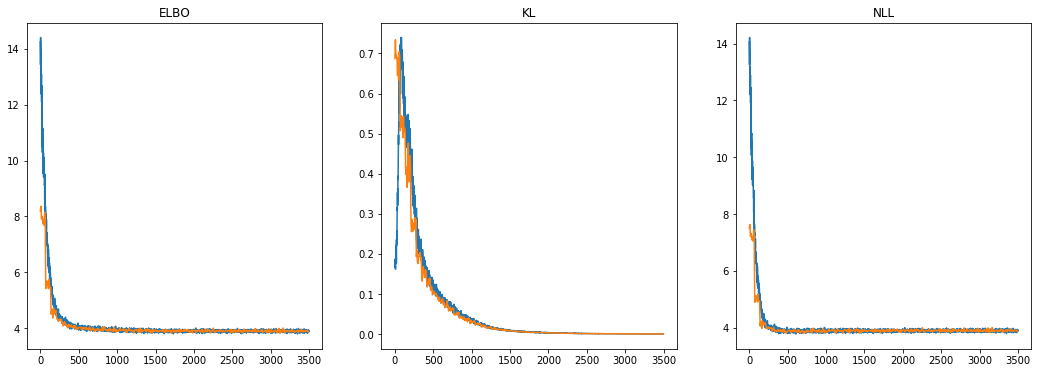

In [0]:
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, False, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(train_b, val_b, test_b)

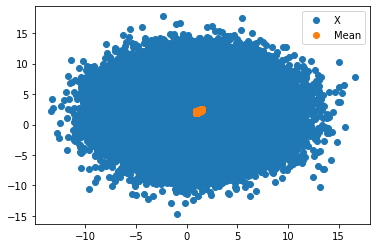

In [0]:
sample(net)

Epoch 0: loss 6.501596776962913 kl 0.2532241642475128 nll 6.2483726127154 
Epoch 10: loss 3.978289937090942 kl 0.05907726660370827 nll 3.8955817645908084 
Epoch 20: loss 3.9145846025991404 kl 0.00898102205246687 nll 3.8984187630909646 
Epoch 30: loss 3.843090618799903 kl 0.0012259574141353369 nll 3.840393512349107 
Epoch 40: loss 3.898907336974514 kl 0.0002965097373817116 nll 3.8981364116631423 
test loss 3.898114165397766  test kl 8.929867908591405e-05 test nll 3.8978498412998137 


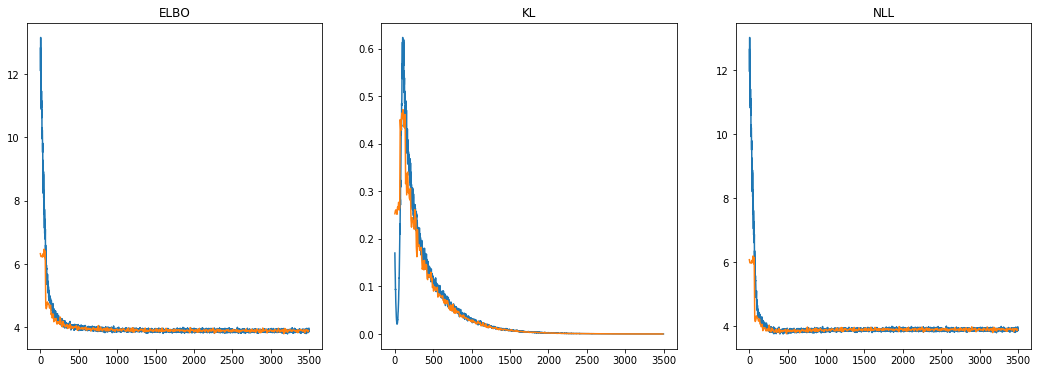

In [0]:
warmup = DeterministicWarmup(max_epochs=25)
net = VariationalAutoencoder(latent_features, num_samples, True, beta=warmup)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
fit(train_b, val_b, test_b)

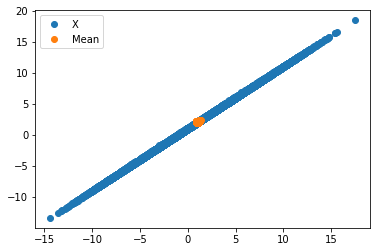

In [0]:
sample(net)